In [1]:
from utils import *
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 16
validation_split = .3
shuffle_dataset = True
random_seed = -999

dataset = DataLoaderSegmentation('dataset-iiit-pet')

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

trainset, testset = torch.utils.data.random_split(dataset, (dataset_size-split, split))

In [2]:
from models import UNet
world_size = 2
mp.spawn(
    runmain,
    args=[UNet, trainset, testset, world_size, 12, {'batch_norm':True}],
    nprocs=world_size
)

[W socket.cpp:401] [c10d] The server socket cannot be initialized on [::]:29505 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [localhost]:29505 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [localhost]:29505 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [localhost]:29505 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [localhost]:29505 (errno: 97 - Address family not supported by protocol).
/scratch365/kho2/Unet/utils.py:79: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /tmpscratch/kho2/.cache/torch/kernels. This warning will appear only once per process. (Trig

Train Epoch: 1 [32/5173 (0%)]	Loss: 0.869560
Train Epoch: 1 [352/5173 (6%)]	Loss: 0.556424
Train Epoch: 1 [672/5173 (12%)]	Loss: 0.440477
Train Epoch: 1 [992/5173 (19%)]	Loss: 0.459924
Train Epoch: 1 [1312/5173 (25%)]	Loss: 0.462395
Train Epoch: 1 [1632/5173 (31%)]	Loss: 0.402166
Train Epoch: 1 [1952/5173 (37%)]	Loss: 0.408480
Train Epoch: 1 [2272/5173 (43%)]	Loss: 0.383120
Train Epoch: 1 [2592/5173 (49%)]	Loss: 0.360582
Train Epoch: 1 [2912/5173 (56%)]	Loss: 0.375039
Train Epoch: 1 [3232/5173 (62%)]	Loss: 0.409322
Train Epoch: 1 [3552/5173 (68%)]	Loss: 0.411798
Train Epoch: 1 [3872/5173 (74%)]	Loss: 0.342925
Train Epoch: 1 [4192/5173 (80%)]	Loss: 0.301309
Train Epoch: 1 [4512/5173 (86%)]	Loss: 0.411406
Train Epoch: 1 [4832/5173 (93%)]	Loss: 0.314732
Train Epoch: 1 [5152/5173 (99%)]	Loss: 0.332799
Test average loss, average IoU: 0.8928056062707579  0.5995017894800159

Train Epoch: 2 [32/5173 (0%)]	Loss: 0.371739
Train Epoch: 2 [352/5173 (6%)]	Loss: 0.426940
Train Epoch: 2 [672/5173 (12

Test average loss, average IoU: 0.5852418122468172  0.6910037717957428

Train Epoch: 11 [32/5173 (0%)]	Loss: 0.225963
Train Epoch: 11 [352/5173 (6%)]	Loss: 0.225695
Train Epoch: 11 [672/5173 (12%)]	Loss: 0.245763
Train Epoch: 11 [992/5173 (19%)]	Loss: 0.222812
Train Epoch: 11 [1312/5173 (25%)]	Loss: 0.281128
Train Epoch: 11 [1632/5173 (31%)]	Loss: 0.234799
Train Epoch: 11 [1952/5173 (37%)]	Loss: 0.269414
Train Epoch: 11 [2272/5173 (43%)]	Loss: 0.236709
Train Epoch: 11 [2592/5173 (49%)]	Loss: 0.268194
Train Epoch: 11 [2912/5173 (56%)]	Loss: 0.242580
Train Epoch: 11 [3232/5173 (62%)]	Loss: 0.233057
Train Epoch: 11 [3552/5173 (68%)]	Loss: 0.267161
Train Epoch: 11 [3872/5173 (74%)]	Loss: 0.230303
Train Epoch: 11 [4192/5173 (80%)]	Loss: 0.285870
Train Epoch: 11 [4512/5173 (86%)]	Loss: 0.232214
Train Epoch: 11 [4832/5173 (93%)]	Loss: 0.253240
Train Epoch: 11 [5152/5173 (99%)]	Loss: 0.220754
Test average loss, average IoU: 0.44776950903752766  0.7067246644393258

Train Epoch: 12 [32/5173 (0%)

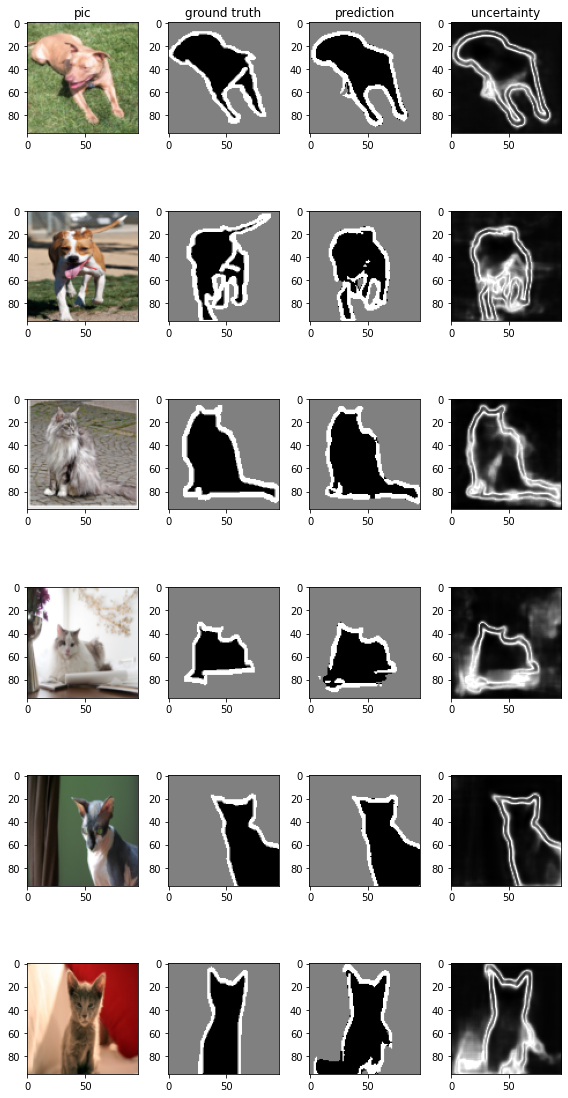

In [5]:
import matplotlib.pyplot as plt
from models import UNet
import torch

nsamples = 6

network = UNet(batch_norm=True)
network.load_state_dict(torch.load('model_unet.pt'), strict=False)
network.eval()

#fig = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(nrows=nsamples, ncols=4, figsize=(8,16))

for i, (example_data, example_targets) in enumerate(testset):
    if i >= nsamples: break
    
#     ColorJitter = transforms.ColorJitter(brightness=(0,1))#, contrast=1, saturation=0.1, hue=0.5)
#     example_data = ColorJitter(example_data)
#    example_data = transforms.functional.rotate(example_data, angle=90, expand=True)
    ax[i][0].imshow(example_data.permute(1, 2, 0))
    ax[i][1].imshow(example_targets.permute(1, 2, 0), cmap='gray')
    
    output = network(example_data.unsqueeze(0)).detach().squeeze() + 1
    prediction = output.argmax(0, keepdim=True)
    ax[i][2].imshow(prediction.permute(1, 2, 0), cmap='gray')
    
    S = torch.sum(output, 0, keepdim=True)
    b = output/S
    u = 1/S
    
    ax[i][3].imshow(u.permute(1, 2, 0), cmap='gray')
    
    if i==0:
        ax[i][0].set_title('pic')
        ax[i][1].set_title('ground truth')
        ax[i][2].set_title('prediction')
        ax[i][3].set_title('uncertainty')
    
fig.tight_layout()  

In [4]:
from torchsummary import summary

#Check network struct
summary(UNet(), (3, 96, 96), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
     UNetConvBlock-5           [-1, 64, 96, 96]               0
            Conv2d-6          [-1, 128, 48, 48]          73,856
              ReLU-7          [-1, 128, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]         147,584
              ReLU-9          [-1, 128, 48, 48]               0
    UNetConvBlock-10          [-1, 128, 48, 48]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256,